## Estimation of activity levels: Part I

This section explains how activity levels are estimated and how they are subsequently used. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings

import emcee
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler
from sklearn.utils.validation import column_or_1d
from tabulate import tabulate
from tsmoothie.smoother import KalmanSmoother

from eensight.methods.prediction.activity import (
    estimate_activity, 
    estimate_activity_markov,
    extract_activity
)
from eensight.methods.prediction.common import train_boost
from eensight.methods.prediction.metrics import cvrmse, nmbe
from eensight.utils import load_catalog

plt.style.use("bmh")

%matplotlib inline

Some utility functions:

In [3]:
def intervals(bin_edges):
    columns = []
    bin_edges = bin_edges.round(1)
    
    for i in range(0, len(bin_edges)-1):
        columns.append(f">{bin_edges[i]} & <={bin_edges[i+1]}")

    return columns


def sigmoid(X: pd.DataFrame, c1: float, c2: float):
    return 1 / (1 + np.exp(-c1 * (X-c2)))


def rescale(X: pd.DataFrame):
    scaler = MinMaxScaler()
    
    return pd.Series(
        scaler.fit_transform(
            column_or_1d(X).reshape(-1, 1)
        ).squeeze(),
        index=X.index
    )

### The *b01* dataset

The *b01* dataset corresponds to the building with `id=4` of the dataset provided by the [EnergyDetective 2020](https://zenodo.org/record/6590976) competition. 

Start with the `train` data:

In [4]:
catalog_train = load_catalog(store_uri="../../../data", site_id="b01", namespace="train")

X_train = catalog_train.load("train.preprocessed-features")
y_train = catalog_train.load("train.preprocessed-labels")

The following plot presents the energy consumption of the selected dataset as a function of the outdoor air (dry bulb) temperature:

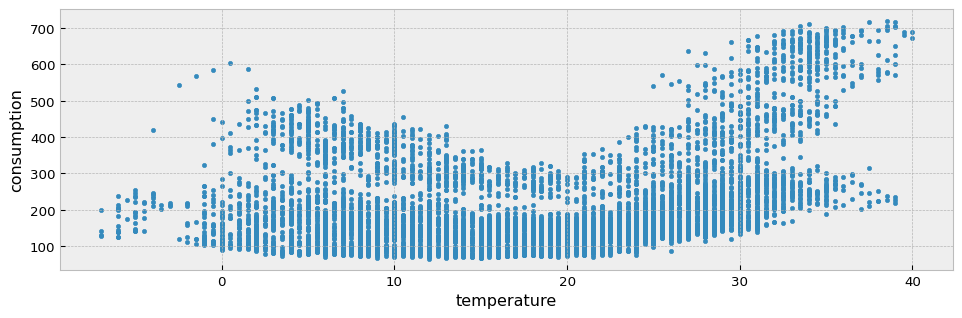

In [5]:
fig = plt.figure(figsize=(12, 3.54), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

ax.scatter(X_train["temperature"], y_train["consumption"], s=10)
ax.set_xlabel("temperature")
ax.set_ylabel("consumption")

### Using a predictive model for energy consumption

Suppose that we want to fit on the `train` data a predictive model for energy consumption that uses:

* calendar features (as a proxy for the building's operation schedule) and 
* weather features.

We already have weather features in the data, 

In [6]:
for feature in X_train.columns:
    print(feature)

temperature
dew point temperature
relative humidity
atmospheric pressure
wind speed


... so let's add the calendar ones:

In [7]:
X_train["hour"] = X_train.index.hour               # hour of day
X_train["day"] = X_train.index.dayofweek           # day of week
X_train["week"] = X_train.index.isocalendar().week # week of year

Now, we can fit a predictive model. 

We can use the [Catboost](https://catboost.ai/) library for gradient boosting on decision trees to build and train the predictive model. `eensight` provides the function `eensight.methods.prediction.common.train_boost` for this purpose. It needs a `validation_size` parameter, which is the percentage of all training data to use for identifying the optimal number of iterations for the Gradient Boosting model (so that to avoid overfitting).

In [20]:
model = train_boost(X_train, y_train, validation_size=0.2)

Next, we can apply the model on the `test` data. First, load the data:

In [9]:
catalog_test = load_catalog(store_uri="../../../data", site_id="b01", namespace="test")

X_test = catalog_test.load("test.preprocessed-features")
y_test = catalog_test.load("test.preprocessed-labels")

Both the `train` and `test` period consumption data are presented in the next plot:

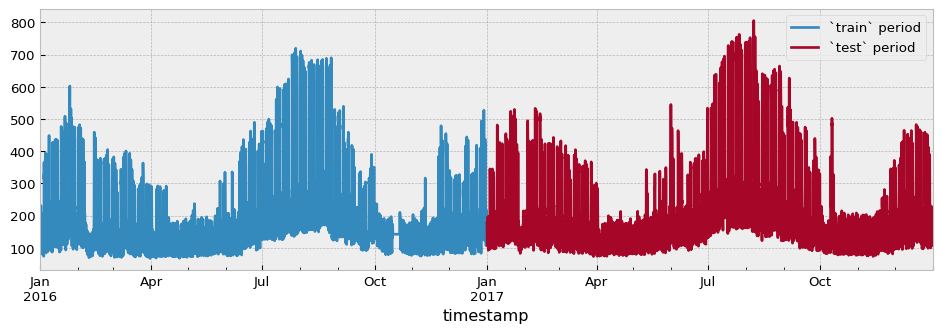

In [10]:
fig = plt.figure(figsize=(12, 3.54), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_train.plot(ax=ax)
y_test.plot(ax=ax)
ax.legend(["`train` period", "`test` period"], frameon=True)

Add calendar features to the `test` data:

In [11]:
X_test["hour"] = X_test.index.hour               # hour of day
X_test["day"] = X_test.index.dayofweek           # day of week
X_test["week"] = X_test.index.isocalendar().week # week of year

Use the trained model to predict energy consumption:

In [21]:
prediction = pd.Series(model.predict(X_test), index=X_test.index).clip(lower=0)

The Coefficient of Variation of the Root Mean Squared Error CV(RMSE) is:

In [22]:
cvrmse(y_test, prediction)

0.236691071780723

The Normalized Mean Bias Error (NMBE) is:

In [23]:
nmbe(y_test, prediction)

0.051646981344470544

We will capture the CV(RMSE) and NMBE values for all the models presented in this section: 

In [24]:
summary = {
    "CV(RMSE)": {},
    "NMBE": {}
}

summary["CV(RMSE)"]["Predictive model"] = cvrmse(y_test, prediction)
summary["NMBE"]["Predictive model"] = nmbe(y_test, prediction)

In addition, we want to know what is achievable (in terms of predictive accuracy) using only the calendar features. We will use this information later on when we will examine the information contained in the estimated `activity` feature.

For this, we will train a model using only calendar features for the `train` data:

In [25]:
X_train_cal = X_train[["hour", "day", "week"]]

model = train_boost(X_train_cal, y_train, validation_size=0.2)

... and apply it on the `test` data:

In [26]:
X_test_cal = X_test[["hour", "day", "week"]]

prediction = pd.Series(model.predict(X_test_cal), index=X_test.index).clip(lower=0)

The CV(RMSE) is:

In [27]:
cvrmse(y_test, prediction)

0.27685025516832096

The NMBE is:

In [28]:
nmbe(y_test, prediction)

0.05317594630937793

In [29]:
summary["CV(RMSE)"]["Predictive model w/ calendar features only"] = cvrmse(y_test, prediction)
summary["NMBE"]["Predictive model w/ calendar features only"] = nmbe(y_test, prediction)

### Estimating activity by a Markov switching regression model

One way to estimate `activity` is to assume that it is a variable that distinguishes all energy consumption observations into two (2) regimes (one regime corresponding to an occupied state and one regime to an unoccupied state). Each regime is described by a different relationship between energy consumption and the most influential occupancy-indepedent feature (`temperature` by default). 

In particular, the underlying model is of the form:

$$consumption_t=f_{s_t}(T_t)+\epsilon_t$$ 

where: 

$consumption_t$ is the energy consumption at time $t$

$T_t$ is the outdoor temperature at time $t$

$\epsilon_t \sim N(0, \sigma^2)$ and 

$s_t \in [0, 1]$ is the active regime at time $t$.

The function `eensight.methods.prediction.activity.estimate_activity_markov` estimates activity levels as the probability of being in the regime that explains the highest energy consumption values: 

In [30]:
act_train = estimate_activity_markov(X_train, y_train, exog="temperature")

The estimated activity levels along with the actual energy consumption for the month of January are presented in the next plot:

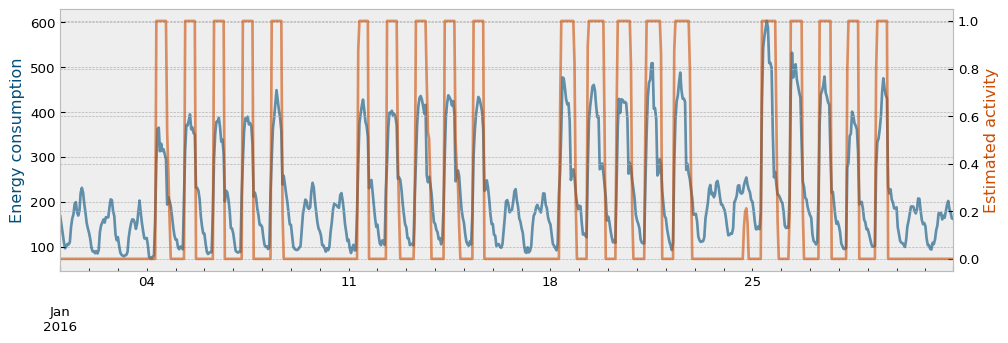

In [31]:
month = 1 # January

fig = plt.figure(figsize=(12, 3.54), dpi=96)
layout = (1, 1)
ax1 = plt.subplot2grid(layout, (0, 0))
ax2 = ax1.twinx()

y_train["consumption"].loc[y_train.index.month==month].plot(ax=ax1, color="#034e7b", alpha=0.6)
act_train.loc[act_train.index.month==month].plot(ax=ax2, color="#cc4c02", alpha=0.6)

ax1.set_ylabel("Energy consumption", color="#034e7b")
ax2.set_ylabel("Estimated activity", color="#cc4c02")

Two (2) questions arise at this point:

1. How well does the estimated activity levels work as a feature to predict energy consumption?


2. We know that we have caused [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)) because we have used energy consumption data to estimate the activity levels in the first place. So this approach is not valid for a predictive task. But, is it valid for an M&V task?

**Q1: How well does the estimated activity levels work as a feature?**

In `eensight`, by convention, there should be no difference between `train` and `test` data. If an event that alters the characteristics of the energy consumption (such as an energy retrofit) has taken place, the post-event data should be in the `apply` namespace. 

As a result, we can exploit the fact that for similar activity levels and similar values of the occupancy-independent variables, energy consumption in `train` and `test` data should be similar. In this way, we can "predict" the energy consumption for the `test` data using the average energy consumption for the same activity and temperature levels in the `train` data. 

Even more importantly, we can estimate the impact of an event by comparing the average energy consumption of the `apply` data to the average energy consumption for the `train` data with the same activity and temperature levels.

As an example, let's isolate all `train` and `test` observations where temperature is lower than 20$^{\circ}C$ and activity levels equal to one (1). First, estimate activity for the `test` data:

In [32]:
act_test = estimate_activity_markov(X_test, y_test, exog="temperature")

Then, select the two (2) subsets:

In [33]:
low_temp_periods_train = X_train[X_train["temperature"] < 20].index

y_train_selected = y_train[
    y_train.index.isin(low_temp_periods_train) 
    & y_train.index.isin(act_train[act_train == 1].index)
]

low_temp_periods_test = X_test[X_test["temperature"] < 20].index

y_test_selected = y_test[
    y_test.index.isin(low_temp_periods_test) 
    & y_test.index.isin(act_test[act_test == 1].index)
]

We can plot the two subsets side by side:

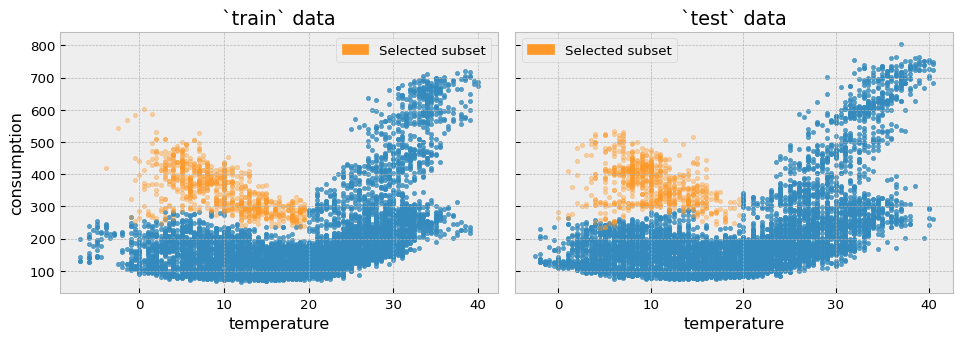

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(12, 3.54), dpi=96)
fig.subplots_adjust(wspace=0.04)

ax1.scatter(
    X_train.loc[~X_train.index.isin(y_train_selected.index), "temperature"], 
    y_train.loc[~y_train.index.isin(y_train_selected.index), "consumption"], 
    s=10, 
    alpha=0.8
)

ax1.scatter(
    X_train.loc[y_train_selected.index, "temperature"], 
    y_train_selected["consumption"], 
    s=10, 
    alpha=0.4,
    color="#fe9929"
)

ax1.set_xlabel("temperature")
ax1.set_ylabel("consumption")
ax1.set_title("`train` data")

ax1.legend(
    handles=[
        mpatches.Patch(color="#fe9929", label="Selected subset"), 
    ]
)

ax2.scatter(
    X_test.loc[~X_test.index.isin(y_test_selected.index), "temperature"], 
    y_test.loc[~y_test.index.isin(y_test_selected.index), "consumption"],
    s=10, 
    alpha=0.8
)

ax2.scatter(
    X_test.loc[y_test_selected.index, "temperature"], 
    y_test_selected["consumption"], 
    s=10, 
    alpha=0.4,
    color="#fe9929"
)

ax2.set_xlabel("temperature")
ax2.set_title("`test` data")

ax2.legend(
    handles=[
        mpatches.Patch(color="#fe9929", label="Selected subset"), 
    ]
)

Since there has been no event that alters the energy consumption between the two periods, the distributions should be similar, and knowing the energy consumption of the `train` period should tell us something about the energy consumption during the `test` period:

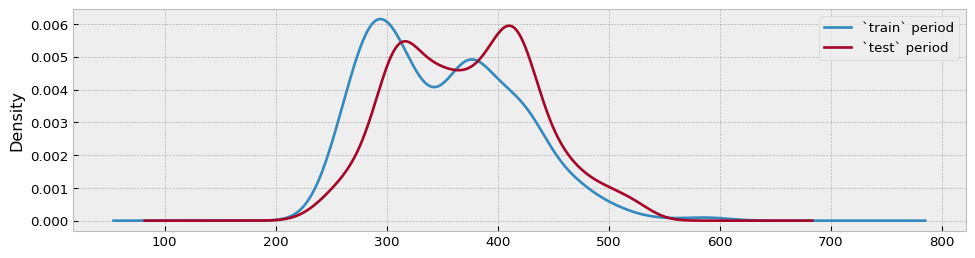

In [35]:
fig = plt.figure(figsize=(12, 3), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_train_selected.plot.kde(ax=ax)
y_test_selected.plot.kde(ax=ax)

ax.legend(["`train` period", "`test` period"], frameon=True)

This is pretty much how a counterfactual prediction should work: find similar conditions between the two datasets (here, similar temperature and activity levels), and compare their energy consumption. To make this approach operational, we can split the `train` temperature into five (5) bins and calculate the average energy consumption per bin and activity level:

In [36]:
n_bins = 5
encoder = KBinsDiscretizer(n_bins=n_bins, encode="ordinal", strategy="uniform")

data_train = pd.concat(
    [
        X_train[["temperature"]], 
        y_train,
        # make activity a binary feature for easier mapping
        act_train.map(lambda x: 0 if x < 0.5 else 1).to_frame("activity")
    ], 
    axis=1
).dropna()

data_train["temperature"] = encoder.fit_transform(data_train[["temperature"]]).astype(int)
data_train = data_train.groupby(["activity", "temperature"]).mean().unstack().droplevel(0, axis=1)

data_train.columns = data_train.columns.map(
    lambda x: intervals(encoder.bin_edges_.item())[x]
)

data_train

temperature,>-7.0 & <=2.4,>2.4 & <=11.8,>11.8 & <=21.2,>21.2 & <=30.6,>30.6 & <=40.0
activity,,,,,
0,149.25767,142.914250,125.647583,172.135394,262.607396
1,373.19614,374.861029,289.907589,392.749730,588.314565


Then, map activity levels and temperature bins between the `train` and the `test` data:

In [37]:
X_test_act = pd.concat(
    [
        X_test[["temperature"]],
        act_test.map(lambda x: 0 if x < 0.5 else 1).to_frame("activity")
    ], 
    axis=1
).dropna()

X_test_act["temperature"] = encoder.transform(X_test_act[["temperature"]]).astype(int)
X_test_act["temperature"] = X_test_act["temperature"].map(
    lambda x: intervals(encoder.bin_edges_.item())[x]
)

prediction = (
    X_test_act.apply(lambda row: data_train.loc[row["activity"], row["temperature"]], axis=1) 
              .reindex(X_test.index)                   
              .fillna(method="ffill")
              .fillna(method="bfill")
)

The actual and the predicted energy consumption are presented in the next plot:

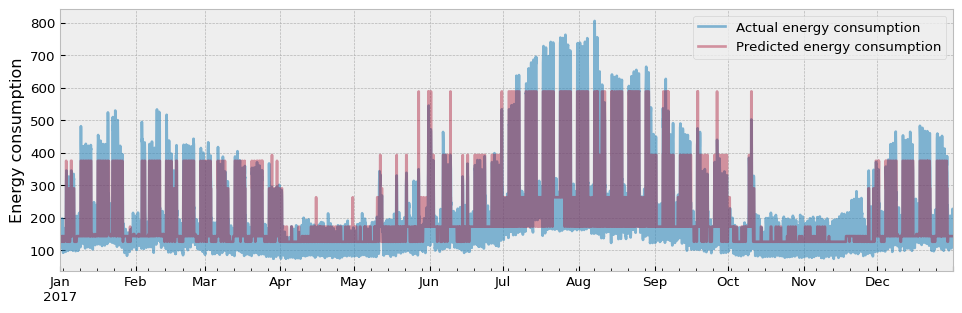

In [38]:
fig = plt.figure(figsize=(12, 3.54), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_test["consumption"].plot(ax=ax, alpha=0.6)
prediction.plot(ax=ax, alpha=0.4)

ax.set_ylabel("Energy consumption")
ax.set_xlabel("")
ax.legend(["Actual energy consumption", "Predicted energy consumption"], frameon=True)

The CV(RMSE) is:

In [39]:
cvrmse(y_test, prediction)

0.25303261894923357

The NMBE is:

In [40]:
nmbe(y_test, prediction)

0.03435777844009265

In [41]:
summary["CV(RMSE)"]["Binning model"] = cvrmse(y_test, prediction)
summary["NMBE"]["Binning model"] = nmbe(y_test, prediction)

What we just did is equivalent to adding the estimated activity levels to the weather-related features of the `train` data, dropping the calendar features (hour of day, day of week, week of year) since we are replacing them with the activity estimation, and learning to predict energy consumption:

In [42]:
X_train_act = pd.concat(
    [
        X_train.drop(["hour", "day", "week"], axis=1),
        act_train.to_frame("activity")
    ], 
    axis=1
)

model = train_boost(X_train_act, y_train, validation_size=0.2)

We can apply the model that was trained with `train` data on the `test` data:

In [43]:
X_test_act = pd.concat(
    [
        X_test.drop(["hour", "day", "week"], axis=1),
        act_test.to_frame("activity")
    ], 
    axis=1
)

# apply the model that was trained with `train` data
prediction = pd.Series(
    model.predict(X_test_act), index=X_test.index
).clip(lower=0)

The actual and the predicted energy consumption are presented in the next plot:

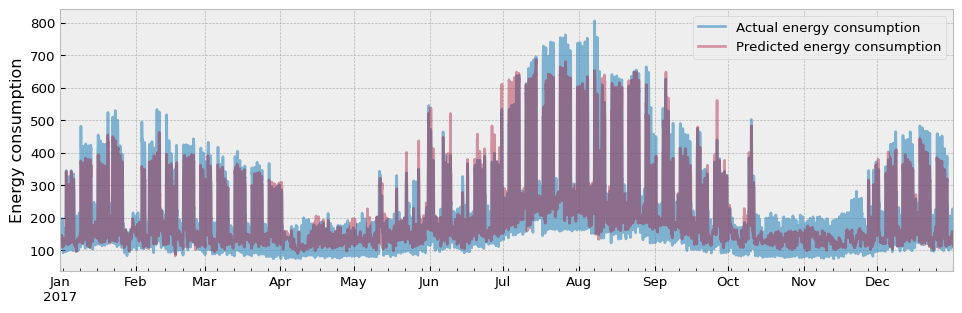

In [44]:
fig = plt.figure(figsize=(12, 3.54), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_test["consumption"].plot(ax=ax, alpha=0.6)
prediction.plot(ax=ax, alpha=0.4)

ax.set_ylabel("Energy consumption")
ax.set_xlabel("")
ax.legend(["Actual energy consumption", "Predicted energy consumption"], frameon=True)

The CV(RMSE) is now:

In [45]:
cvrmse(y_test, prediction)

0.2200642085109248

And the NMBE:

In [46]:
nmbe(y_test, prediction)

0.03881894580152023

Although `eensight` does not use deep learning techniques, the best way to describe the last model is as a combination of [autoencoders](https://en.wikipedia.org/wiki/Autoencoder). One autoencoder model is developed using `train` data: it uses energy consumption data to identify activity levels conditioned on the occupancy-independent features (encoder) and, then, uses the activity levels and the occupancy-independent features to reconstruct the energy consumption (decoder). The other autoencoder model is developed similarly using `test` or `apply` data. 

The M&V model is derived by combining the activity estimation of the `test` or `apply` data (second encoder) with the energy consumption model that was trained using the `train` data (first decoder). This concept is summarized in the following diagram:  


![Autoencoder scheme](../../../images/autoencoder.png)

In [47]:
summary["CV(RMSE)"]["Autoencoding model w/ markov activity"] = cvrmse(y_test, prediction)
summary["NMBE"]["Autoencoding model w/ markov activity"] = nmbe(y_test, prediction)

We will also fit and evaluate a predictive model that uses a binary version of the estimated activity levels:

In [48]:
X_train_act = pd.concat(
    [
        X_train.drop(["hour", "day", "week"], axis=1),
        act_train.map(lambda x: 0 if x < 0.5 else 1).to_frame("activity")
    ], 
    axis=1
)

model = train_boost(X_train_act, y_train, validation_size=0.2)

X_test_act = pd.concat(
    [
        X_test.drop(["hour", "day", "week"], axis=1),
        act_test.map(lambda x: 0 if x < 0.5 else 1).to_frame("activity")
    ], 
    axis=1
)

# apply the model that was trained with `train` data
prediction = pd.Series(
    model.predict(X_test_act), index=X_test.index
).clip(lower=0)

cvrmse(y_test, prediction)

0.23237372671484366

In [49]:
summary["CV(RMSE)"]["Autoencoding model w/ binary activity"] = cvrmse(y_test, prediction)
summary["NMBE"]["Autoencoding model w/ binary activity"] = nmbe(y_test, prediction)

**Q2: Is this a valid approach for M&V?**

If we treat M&V as a pure prediction task, it is not, and this is because we use `test` consumption data to estimate activity levels in the first place. However, M&V is not a prediction task, it is an impact assessment task. The autoencoding model above is a valid counterfactual model that follows this general template:

**When used on `train` data**

1. Estimate activity levels (i.e. estimate the value of a mapping variable)
2. Train a model that predicts consumption given activity levels and occupancy-independent features

**When used on `test` or `apply` data**

1. Estimate activity levels (i.e. adjust a mapping variable based on the available data)
2. Apply the model to predict the consumption that corresponds to similar activity levels and occupancy-independent features' values in the `train` data. 

Here, we use this approach for `test` data, but it is mainly meant to be used for data before (`train`) and after (`apply`) an energy retrofit. Since we will start collecting `apply` data during the reporting period, we can estimate activity levels and map their values back to the energy consumption of the `train` data.

Since the autoencoding models are not valid models for prediction, we don't evaluate the CV(RMSE) to see how much it was improved. Instead, we look at the CV(RMSE) to ensure that it is close to the results from the monolithic model, which *is* a valid model for prediction tasks. This will assure us that the proposed approach does not overfit and, as a result, we can trust it when applied on post-retrofit data as well.  

### Allowing activity estimation to overfit the data

`eensight` provides the `eensight.methods.prediction.activity.extract_activity` function as a way to remove from the energy consumption data the impact of the features that are independent of the building's operation (such as outdoor temperature). 

The `extract_activity` function employs a fast, heuristic approach that performs two (2) quantile regressions of the consumption data as function of the occupancy-independent features: one regression at the `0.99` quantile and one at the `0.01` one. Then, all observations are normalized to the `[0, 1]` interval using the range of the corresponding 0.99-quantile and 0.01-quantile predictions.

In [50]:
for feature in X_train.columns:
    print(feature)

temperature
dew point temperature
relative humidity
atmospheric pressure
wind speed
hour
day
week


Drop the calendar features and use all weather features as occupancy-independent features:

In [51]:
X_train = X_train.drop(["hour", "day", "week"], axis=1)
X_test = X_test.drop(["hour", "day", "week"], axis=1)

non_occ_features = [
    "temperature", 
    "dew point temperature", 
    "relative humidity",
    "atmospheric pressure", 
    "wind speed",
]

In [52]:
act_train = extract_activity(X_train, y_train, non_occ_features=non_occ_features)

The estimated activity levels are presented in the following plot:

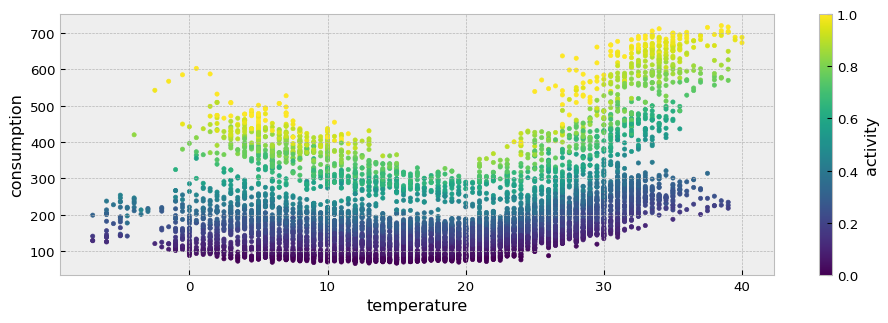

In [53]:
plot_data = pd.concat(
    [
        X_train[["temperature"]], 
        y_train,
        act_train.to_frame("activity")
    ], 
    axis=1
)

plot_data = plot_data.sort_values(by="temperature")

fig = plt.figure(figsize=(12, 3.54), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

plot_data.plot.scatter("temperature", "consumption", c="activity", colormap='viridis', s=10, ax=ax)

Note that the `extract_activity` function **significantly overfits** the data. In other words, it assumes that the `activity` feature explains **all** the variation of the energy consumption that cannot be explained by the occupancy-independent features. 

One way to verify that the `extract_activity` function does indeed overfit the data is to use its result as a feature for predicting energy consumption. For this, we can add the estimated activity to the weather features, and train a new predictive model.  

In [54]:
X_train_act = pd.concat(
    [
        X_train,
        act_train.to_frame("activity")
    ],
    axis=1
)

model, scores = train_boost(X_train_act, y_train, validation_size=0.2, return_scores=True)

The `scores` variable is a dictionary with the regression metrics for the data used for training (`learn` key) and for validation (`validation` key):

In [55]:
scores

{
    'learn': {'RMSE': 2.0079791342431044, 'CVRMSE': 0.010091042459968107},
    'validation': {'RMSE': 1.9624404160731104, 'CVRMSE': 0.011481690145716752}
}

The low CV(RMSE) values are a telltale sign that overfitting is at play. 

We will apply `extract_activity` on the `test` data too:

In [56]:
act_test = extract_activity(X_test, y_test, non_occ_features=non_occ_features)

And use the trained model to predict on the `test` data:

In [57]:
X_test_act = pd.concat(
    [
        X_test,
        act_test.to_frame("activity")
    ], 
    axis=1
)

# apply the model that was trained with `train` data
prediction = pd.Series(
    model.predict(X_test_act), index=X_test.index
).clip(lower=0)

cvrmse(y_test, prediction)

0.07502353241243263

>Any approach to estimating the `activity` feature that leads to a prediction on the `test` data with a CV(RMSE) significantly lower than the value we achieved with the pure predictive model (~ 23%) should be suspected for overfitting the data.

In [58]:
summary["CV(RMSE)"]["Autoencoding model w/ overfitting activity"] = cvrmse(y_test, prediction)
summary["NMBE"]["Autoencoding model w/ overfitting activity"] = nmbe(y_test, prediction)

### Correcting the activity estimation

We can argue that the most useful estimation of the `activity` feature is somewhere between: 

* the binary activity (which may underfit because it removes information for intermediate levels of activity) and 

* the one returned by the `extract_activity` (which significantly overfits). 

To move between these two extremes, we can impose a [sigmoid](https://en.wikipedia.org/wiki/Sigmoid_function) transformation on the estimated activity:


$$\large f(x)=\frac{1}{1+e^{-c_1 * (x-c_2)}}$$

The idea behind the sigmoid transformation is that many low values of activity may in fact be zero activity plus noise, many high values of activity may in fact be full activity plus noise, and values in between may represent different intermediate conditions. The different shapes of the sigmoid transformation are presented in the next plot:   

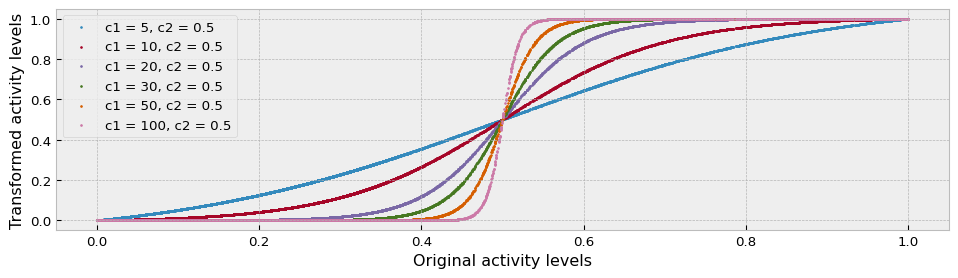

In [59]:
labels = []
c1_values = [5, 10, 20, 30, 50, 100]
c2 = 0.5

fig = plt.figure(figsize=(12, 3), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

for c1 in c1_values:
    act_train_trimmed = act_train.pipe(sigmoid, c1, c2).pipe(rescale)
    ax.scatter(act_train, act_train_trimmed, s=2)
    labels.append(f"c1 = {c1}, c2 = 0.5")

ax.set_xlabel("Original activity levels")
ax.set_ylabel("Transformed activity levels")
ax.legend(labels, frameon=True)

To understand better how we could optimally parameterize the sigmoid transformation, we can use the transformed activity levels as features, fit a predictive model for energy consumption given the transformed activity and weather data in the `train` period, and evaluate it using the transformed activity and the weather data of the `test` period.

In [60]:
c1_values = [5, 10, 20, 25, 30, 40, 50, 100]
c2 = 0.5
accuracy = []

for c1 in c1_values:
    # we round up and down to remove small variations 
    # (values at almost one or values that are almost
    # zero) that may be picked up by a predicitive model   
    act_train_trimmed = (
        act_train
        .pipe(sigmoid, c1, c2)
        .pipe(rescale)
        .map(lambda x: 0 if x < 0.1 else 1 if x > 0.9 else x)
    )
                                 
    
    X_train_act = pd.concat(
        [
            X_train,
            act_train_trimmed.to_frame("activity")
        ],
        axis=1
    )

    model = train_boost(X_train_act, y_train)
    
    act_test_trimmed = (
        act_test
        .pipe(sigmoid, c1, c2)
        .pipe(rescale)
        .map(lambda x: 0 if x < 0.1 else 1 if x > 0.9 else x)
    )

    X_test_act = pd.concat(
        [
            X_test,
            act_test_trimmed.to_frame("activity")
        ],
        axis=1
    )
    
    pred = pd.Series(model.predict(X_test_act), index=y_test.index)
    accuracy.append(cvrmse(y_test, pred))

The next plot shows what we should have been expecting: the larger the correction, the higher the CV(RMSE).

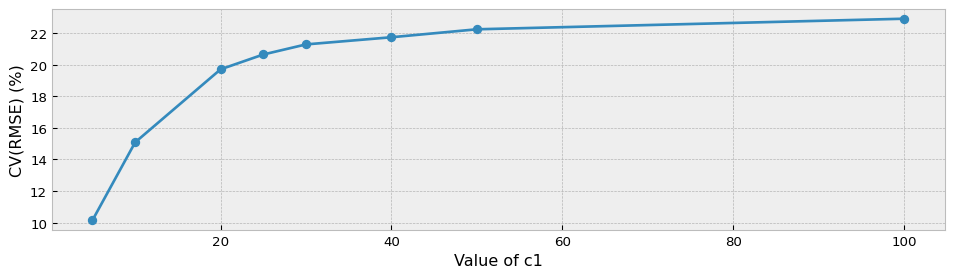

In [61]:
fig = plt.figure(figsize=(12, 3), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

pd.Series(accuracy, index=c1_values).map(lambda x: 100*x).plot(ax=ax, style="-o")

ax.set_xlabel("Value of c1")
ax.set_ylabel("CV(RMSE) (%)")

But, how do we know which parameters to choose for the sigmoid transformation? In other words, 

>*How do we know which accuracy levels are low because of overfitting and which are high due to over-correction?* 

The approach that `eensight` adopts is based on the idea that the optimal `c1` value is the one that minimizes the difference between the CV(RMSE) of an autoencoding model when applied on the `train` data and the CV(RMSE) of the same model when applied to a denoised/smoothed version of the `train` energy consumption data. Since the `extract_activity` function overfits the energy consumption data, this difference is a good enough proxy for the degree of overfitting.   

The denoised version of the `train` energy consumption data is calculated as follows:

In [62]:
smoother = KalmanSmoother(component="level", component_noise={"level": 0.1})
smoother = smoother.smooth(y_train)

y_train_dn = pd.Series(smoother.smooth_data[0], index=y_train.index)
y_train_dn.loc[y_train[y_train["consumption"] <= 1e-05].index] = 0

The actual and the denoised energy consumption for the month of January are presented in the next plot:

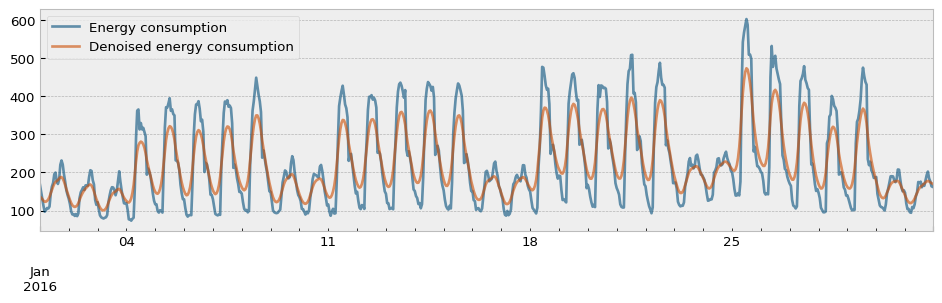

In [63]:
month = 1 # January

fig = plt.figure(figsize=(12, 3), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_train["consumption"].loc[y_train.index.month==month].plot(
    ax=ax, color="#034e7b", alpha=0.6
)
y_train_dn.loc[y_train_dn.index.month==month].plot(
    ax=ax, color="#cc4c02", alpha=0.6
)

ax.legend(["Energy consumption", "Denoised energy consumption"], frameon=True)

Next, we will calculate our overfitting proxy for different values of the `c1` parameter (keeping `c2` constant):

In [64]:
c1_values = [5, 10, 20, 25, 30, 35, 40, 45, 50, 55, 60]
c2 = 0.5
results = []

for c1 in c1_values:
    act_train_trimmed = (
        act_train
        .pipe(sigmoid, c1, c2)
        .pipe(rescale)
        .map(lambda x: 0 if x < 0.1 else 1 if x > 0.9 else x)
    )
                                 
    X_train_act = pd.concat(
        [
            X_train,
            act_train_trimmed.to_frame("activity")
        ],
        axis=1
    )

    model = train_boost(X_train_act, y_train)

    # apply the model on the smoothed data
    prediction = pd.Series(model.predict(X_train_act), index=y_train.index)
   
    results.append(cvrmse(y_train_dn, prediction) - cvrmse(y_train, prediction))
    
results = pd.Series(results, index=c1_values)

The evolution of the overfitting proxy is presented below: 

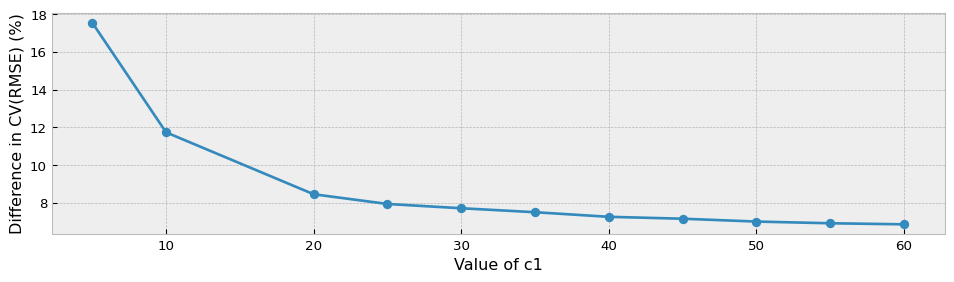

In [65]:
fig = plt.figure(figsize=(12, 3), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

results.map(lambda x: 100*x).plot(ax=ax, style="-o")

ax.set_xlabel("Value of c1")
ax.set_ylabel("Difference in CV(RMSE) (%)")

In order to find a compromise between reducing the difference in the CV(RMSE) values and the degree of correction (value of `c1`), we seek the maximum of the following vector:

In [66]:
opt = ((results - results.iloc[0]) / results.iloc[0]).abs() - 0.005*results.index

The first term of the formula above rewards reductions in the overfitting proxy compared to its initial value, and the second term penalizes for the value of the `c1` parameter. The evolution of both the overfitting proxy and the optimization objective are presented below:

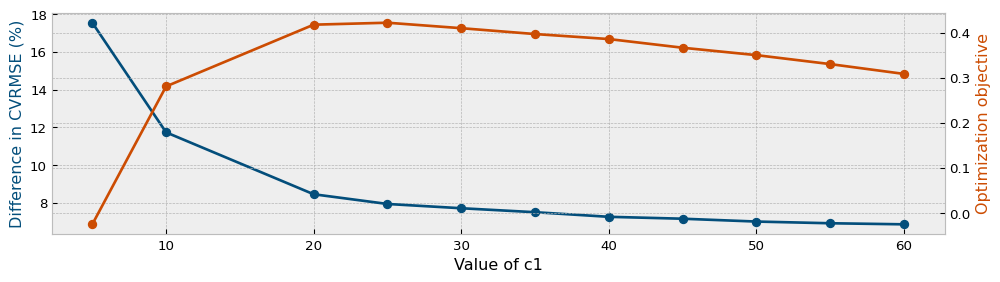

In [67]:
fig = plt.figure(figsize=(12, 3), dpi=96)
layout = (1, 1)
ax1 = plt.subplot2grid(layout, (0, 0))
ax2 = ax1.twinx()

results.map(lambda x: 100*x).plot(ax=ax1, style="-o", color="#034e7b")
opt.plot(ax=ax2, style="-o", color="#cc4c02")

ax1.set_xlabel("Value of c1")
ax1.set_ylabel("Difference in CVRMSE (%)", color="#034e7b")
ax2.set_ylabel("Optimization objective", color="#cc4c02")

The function `eensight.methods.prediction.activity.estimate_activity` optimizes the values for the parameters `c1` and `c2`.

`c2` is selected based on the objective that the output of the `extract_activity` function should approximate the shape implied by the results of the `estimate_activity_markov` function. 

First, we will estimate the activity levels for the `train` and the `test` data using the `estimate_activity` function:

In [68]:
act_train, best_params = estimate_activity(
    X_train, 
    y_train, 
    non_occ_features=non_occ_features, 
    exog="temperature",
    return_params=True
)

best_params

{'c1': 23.0, 'c2': 0.4976250842770019}

In [69]:
act_test, best_params = estimate_activity(
    X_test, 
    y_test, 
    non_occ_features=non_occ_features, 
    exog="temperature",
    return_params=True
)

best_params

{'c1': 24.0, 'c2': 0.5050037082333166}

Then, use the `train` activity levels as features for an energy consumption model,

In [70]:
X_train_act = pd.concat(
    [
        X_train,
        act_train.to_frame("activity")
    ],
    axis=1
)

... fit the predictive model for energy consumption given the estimated activity and the weather data in the `train` period,

In [71]:
model = train_boost(X_train_act, y_train)

... and evaluate the model using the estimated activity levels and the weather data of the `test` period:

In [72]:
X_test_act = pd.concat(
    [
        X_test,
        act_test.to_frame("activity")
    ],
    axis=1
)

prediction = pd.Series(
    model.predict(X_test_act), index=X_test.index
).clip(lower=0)

The CV(RMSE) is now:

In [73]:
cvrmse(y_test, prediction)

0.22064467499835222

And the NMBE is:

In [74]:
nmbe(y_test, prediction)

0.04838481617334579

In [75]:
summary["CV(RMSE)"]["Autoencoding model w/ corrected activity"] = cvrmse(y_test, prediction)
summary["NMBE"]["Autoencoding model w/ corrected activity"] = nmbe(y_test, prediction)

The estimated activity levels, along with the actual energy consumption for the `train` period and the month of January are presented in the next plot:

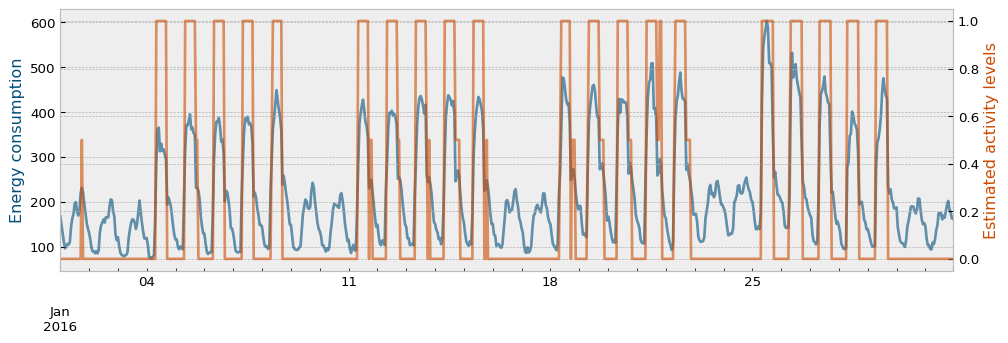

In [76]:
month = 1 # January

fig = plt.figure(figsize=(12, 3.54), dpi=96)
layout = (1, 1)
ax1 = plt.subplot2grid(layout, (0, 0))
ax2 = ax1.twinx()

y_train["consumption"].loc[y_train.index.month==month].plot(ax=ax1, color="#034e7b", alpha=0.6)
act_train.loc[act_train.index.month==month].plot(ax=ax2, color="#cc4c02", alpha=0.6)

ax1.set_ylabel("Energy consumption", color="#034e7b")
ax2.set_ylabel("Estimated activity levels", color="#cc4c02")

There is an additional aspect to verify. For the `activity` feature to be useful in the autoencoding scheme, it must be hard to reconstruct the energy consumption when given `activity` alone, but easy if `activity` is provided along with the features that are independent of the building's operation and were used for activity level estimation.  

We can verify this by dropping the additional features and using only the estimated activity to predict energy consumption. Let's re-train a model using only the estimated activity levels for the `train` period.

In [77]:
model = train_boost(act_train.to_frame("activity"), y_train, validation_size=0.2)

And evaluate the model on the `test` data:

In [78]:
prediction = pd.Series(
    model.predict(act_test.to_frame("activity")), 
    index=X_test.index
).clip(lower=0)

cvrmse(y_test, prediction)

0.339086268512483

In [79]:
summary["CV(RMSE)"]["Autoencoding model w/ activity only"] = cvrmse(y_test, prediction)
summary["NMBE"]["Autoencoding model w/ activity only"] = nmbe(y_test, prediction)

The difference is ~50%, which indicates that it is indeed not easy to reconstruct the energy consumption when given `activity` alone.

The summary of the CV(RMSE) values of all the models explored in this section is presented in the next plot:

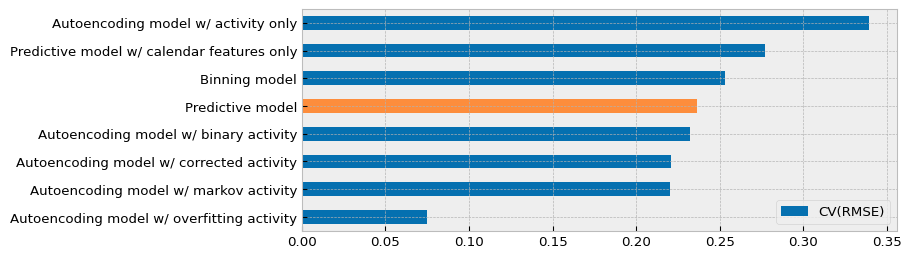

In [81]:
summary = pd.DataFrame.from_dict(summary)

fig = plt.figure(figsize=(8, 3), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

summary1 = summary[["CV(RMSE)"]].sort_values(by="CV(RMSE)")
summary2 = summary1.copy()

summary1.loc["Monolithic model"] = 0
summary2.loc[[name for name in summary.index if name != "Predictive model"]] = 0

summary1.plot.barh(ax=ax, color="#0570b0")
summary2.plot.barh(ax=ax, color="#fd8d3c", legend=False)

There are two (2) conclusions to be made from the plot above:

1. When dealing with buildings where energy consumption is easy to predict using the outdoor temperature and calendar features, the autoencoding model gives results that are similar to the monolithic model. 


2. The estimated activity feature does not contain more information than the calendar features that it replaces. 

These conclusions should mitigate concerns for potential overfitting due to data leakage, which can arise when dealing with buildings where calendar features are not very predictive of energy consumption, but the autoencoding approach can still provide acceptable results (because it **directly estimates activity levels instead of predicting them**). 

Finally, the summary of the NMBE values of all the models is presented in the next plot:

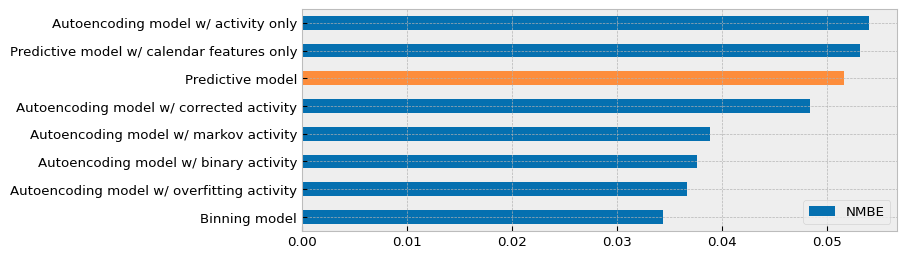

In [82]:
fig = plt.figure(figsize=(8, 3), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

summary1 = summary[["NMBE"]].sort_values(by="NMBE")
summary2 = summary1.copy()

summary1.loc["Monolithic model"] = 0
summary2.loc[[name for name in summary.index if name != "Predictive model"]] = 0

summary1.plot.barh(ax=ax, color="#0570b0")
summary2.plot.barh(ax=ax, color="#fd8d3c", legend=False)

### Disaggregating predictions

`eensight` offers a way to split an energy consumption prediction into temperature-dependent and temperature-independent components. For this, it uses the model's predictions to estimate some first-principle parameters of the underlying building. 

In particular, it assumes that the energy consumption of the building is governed by the following system of equations:  

*if activity > 0* :

$$Q_{con} = A * U * max(0, T_{out} - T_{sp}^{coo}, T_{sp}^{hea} - T_{out})$$

$$Q_{ven} = \frac{1}{3600} * (1- \eta) * c_{p} * \rho * ACH * V * max(0, T_{out} - T_{sp}^{coo}, T_{sp}^{hea} - T_{out})$$


*else (activity = 0)* :

$$Q_{con} = A * U * max(0, T_{out} - T_{sb}^{coo}, T_{sb}^{hea} - T_{out})$$


*for all values of activity* :

$$Q_{plug} = \alpha * activity + \beta$$

where:

$A$ : Area of building exposed to outdoors $(m^2)$

$U$ : U value of envelope $(W/(m^2*K))$ 

$T_{out}$ : Outdoor air temperature $(K)$

$T_{sp}^{coo}$ : Setpoint indoor air temperature for cooling $(K)$

$T_{sp}^{hea}$ : Setpoint indoor air temperature for heating $(K)$

$T_{sb}^{coo}$ : Setback indoor air temperature for cooling $(K)$

$T_{sb}^{hea}$ : Setback indoor air temperature for heating $(K)$

$\eta$ : Heat recovery efficiency (%)

$c_{p}$ : Specific heat capacity of air $(J/(kg*K))$

$\rho$ : Density of air $(kg/m^3)$

$ACH$ : Air changes per hour

$V$ : Air volume of building $(m^3)$

$\alpha, \beta$ : Parameters for a linear relationship between activity levels and plug load

$Q_{con}$ : Air conditioning load $(W)$

$Q_{ven}$ : Ventilation load $(W)$

$Q_{plug}$ : Plug load $(W)$

The estimation of the building's parameters is be done using [Markov chain Monte Carlo](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo), so we need to define the priors for the parameters:

$$U \sim Uniform(0.5, 5)$$

$$T_{sp}^{coo} \sim Uniform(273.15 + 24, 273.15 + 27)$$

$$T_{sp}^{hea} \sim Uniform(273.15 + 20, 273.15 + 24)$$

$$T_{sb}^{coo} \sim Uniform(273.15 + 24, 273.15 + 35)$$

$$T_{sb}^{hea} \sim Uniform(273.15 + 5, 273.15 + 20)$$

$$\eta \sim Uniform(0, 1)$$

$$ACH \sim Uniform(0.3, 5)$$

$$\alpha \sim Uniform(0, max(consumption) - min(consumption))$$

$$\beta \sim Uniform(0, min(consumption))$$

The relevant functionality is provided by the function `eensight.methods.prediction.baseline.explain_predicition`.

First, `explain_predicition` defines a log-prior function:

In [78]:
def log_prior(theta, y):
    u_value, T_sp_coo, T_sp_hea, T_sb_coo, T_sb_hea, eta, ach, alpha, beta = theta
    
    if (
        (0.5 < u_value < 5)
        and (273.15 + 24 < T_sp_coo < 273.15 + 27)
        and (273.15 + 20 < T_sp_hea < 273.15 + 24)
        and (273.15 + 24 < T_sb_coo < 273.15 + 35)
        and (273.15 + 5 < T_sb_hea < 273.15 + 20)
        and (0 < eta < 1)
        and (0.3 < ach < 5)
        and (0 < alpha < y.max() - y.min())
        and (0 < beta < y.min())
    ):
        return 0.0
    
    return -np.inf

Next, it defines a forward model:

In [79]:
def forward_model(theta, temperature, activity, A, V, cp, rho):
    u_value, T_sp_coo, T_sp_hea, T_sb_coo, T_sb_hea, eta, ach, alpha, beta = theta

    # air conditioning load when activity is positive
    cond_load_on = (
        A
        * u_value
        * np.maximum(temperature - T_sp_coo, T_sp_hea - temperature)
        .clip(lower=0)
        .pipe(lambda x: x.mask(activity <= 1e-05, 0))
    )

    # ventilation load
    ven_load = (
        (1 / 3600)
        * (1 - eta)
        * cp
        * rho
        * ach
        * V
        * np.maximum(temperature - T_sp_coo, T_sp_hea - temperature)
        .clip(lower=0)
        .pipe(lambda x: x.mask(activity <= 1e-05, 0))
    )

    # air conditioning load when activity is zero
    cond_load_off = (
        A
        * u_value
        * np.maximum(temperature - T_sb_coo, T_sb_hea - temperature)
        .clip(lower=0)
        .pipe(lambda x: x.mask(activity > 1e-05, 0))
    )

    # plug load
    plug_load = alpha * activity + beta

    return cond_load_on, ven_load, cond_load_off, plug_load

Defines the log-likelihood:

In [80]:
def log_likelihood(theta, temperature, activity, y, A, V, cp, rho):
    _, T_sp_coo, T_sp_hea, T_sb_coo, T_sb_hea, eta, _, _, _ = theta

    if (
        (T_sp_coo < T_sp_hea)
        or (T_sb_coo < T_sb_hea)
        or (T_sp_coo > T_sb_coo)
        or (T_sp_hea < T_sb_hea)
        or (eta > 1)
        or (eta < 0)
    ):
        return -np.inf

    cond_load_on, ven_load, cond_load_off, plug_load = forward_model(
        theta, temperature, activity, A, V, cp, rho
    )
    total_load = cond_load_on + ven_load + cond_load_off + plug_load

    return -0.5 * np.sum((y - total_load) ** 2)

The full log-probability function is:

In [81]:
def log_probability(theta, temperature, activity, y, A, V, cp, rho):
    lp = log_prior(theta, y)

    if not np.isfinite(lp):
        return -np.inf

    return lp + log_likelihood(theta, temperature, activity, y, A, V, cp, rho)

The function to run the MCMC estimations is defined as:

In [82]:
def run_mcmc(X, y, *, A, V, cp, rho):
    nwalkers = 100
    ndim = 9 # number of parameters to estimate

    temperature = X["temperature"] + 273.15
    activity = X["activity"]

    sampler = emcee.EnsembleSampler(
        nwalkers, ndim, log_probability, args=(temperature, activity, y, A, V, cp, rho)
    )

    # initial values
    pos = np.array(
        [
            1,              # u_value 
            273.15 + 25,    # T_sp_coo 
            273.15 + 20,    # T_sp_hea 
            273.15 + 35,    # T_sb_coo
            273.15 + 10,    # T_sb_hea
            0.5,            # eta 
            2,              # ach
            y.min(),        # alpha
            y.min()/2       # beta
        ]
    )
    pos = np.tile(pos, (nwalkers, 1)) + np.random.randn(nwalkers, ndim)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=RuntimeWarning)
        sampler.run_mcmc(pos, 1000, progress=False)
    
    chain = sampler.get_chain(discard=100, thin=15, flat=True)
    return chain

Now, let's estimate the parameters of the building based on the predictions of an autoencoding model that has been trained using `train` data and applied on `test` data.

Get the prediction:

In [83]:
X_train_act = pd.concat(
    [
        X_train,
        act_train.to_frame("activity")
    ],
    axis=1
)

model = train_boost(X_train_act, y_train, validation_size=0.2)

X_test_act = pd.concat(
    [
        X_test,
        act_test.to_frame("activity")
    ],
    axis=1
)

prediction = pd.Series(
    model.predict(X_test_act), index=X_test.index
).clip(lower=0)

Estimate the building's parameters:

In [84]:
X_test_act = X_test_act.dropna()
prediction = prediction.loc[X_test_act.index]

samples = run_mcmc(X_test_act, prediction, A=30, V=90, cp=1.005, rho=1.2)

The estimated values for the parameters are:

In [85]:
parameters = [
    "u_value", 
    "T_sp_coo", 
    "T_sp_hea", 
    "T_sb_coo", 
    "T_sb_hea", 
    "eta", 
    "ach", 
    "alpha", 
    "beta"
]

theta = samples.mean(axis=0)

results = {
    param: val - 273.15 
           if param in ["T_sp_coo", "T_sp_hea", "T_sb_coo", "T_sb_hea", ] 
           else val
           for param, val in zip(parameters, theta)
}

table = []

for param, val in results.items():
    table.append([param, round(val, 2)])
    
print(tabulate(table, headers=["Parameter", "Estimated value"]))

Parameter      Estimated value
-----------  -----------------
u_value                   0.86
T_sp_coo                 24.41
T_sp_hea                 20.58
T_sb_coo                 28.63
T_sb_hea                  8.52
eta                       0.51
ach                       2.94
alpha                    59.74
beta                     50.27


We can estimate the HVAC load based on the forward model and the estimated parameters for the building:

In [86]:
temperature = X_test_act["temperature"] + 273.15
activity = X_test_act["activity"]

cond_load_on, ven_load, cond_load_off, plug_load = forward_model(
    theta, 
    temperature, 
    activity,
    30, 
    90, 
    1.005, 
    1.2
)

hvac_load = cond_load_on.add(cond_load_off).add(ven_load)

... and plot the HVAC load estimation along with the actual energy consumption:

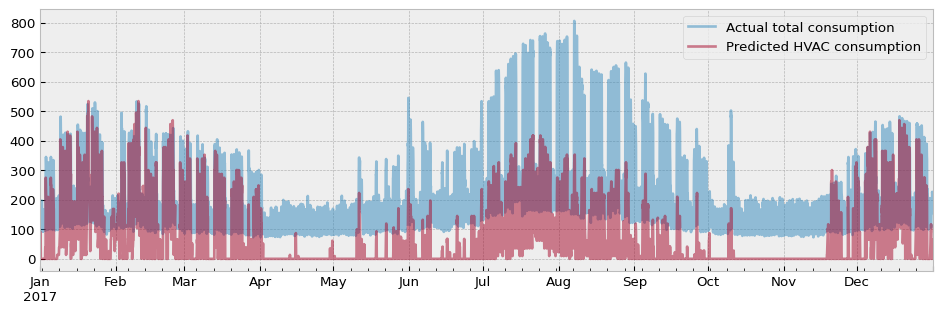

In [87]:
fig = plt.figure(figsize=(12, 3.54), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_test["consumption"].plot(ax=ax, alpha=0.5)
hvac_load.plot(ax=ax, alpha=0.5)

ax.set_xlabel("")
ax.legend(["Actual total consumption", "Predicted HVAC consumption"], frameon=True)

And we will do the same for the predicted plug load:

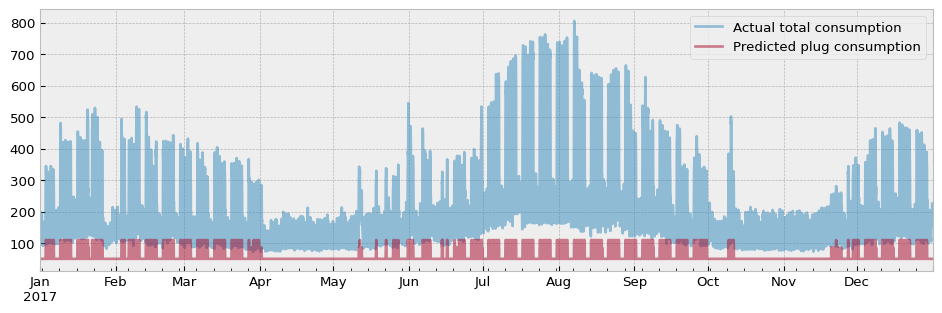

In [88]:
fig = plt.figure(figsize=(12, 3.54), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

y_test["consumption"].plot(ax=ax, alpha=0.5)
plug_load.plot(ax=ax, alpha=0.5)

ax.set_xlabel("")
ax.legend(["Actual total consumption", "Predicted plug consumption"], frameon=True)

There is the final argument to support the claim that the estimated activity levels do not cause overfitting due to data leakage: 

>If data leakage caused overfitting, the estimated plug load would explain most of the energy consumption, and the estimated HVAC load will be minimal. 

Finally, we can plot the total predicted consumption along with the actual one:

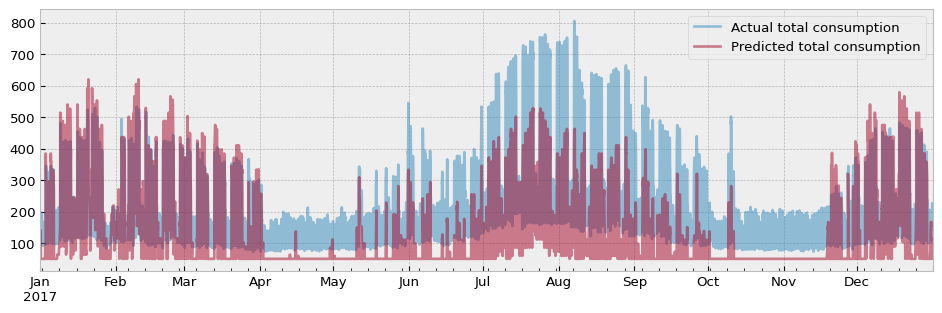

In [89]:
fig = plt.figure(figsize=(12, 3.54), dpi=96)
layout = (1, 1)
ax = plt.subplot2grid(layout, (0, 0))

total_predicted = hvac_load + plug_load

y_test["consumption"].plot(ax=ax, alpha=0.5)
total_predicted.plot(ax=ax, alpha=0.5)

ax.set_xlabel("")
ax.legend(["Actual total consumption", "Predicted total consumption"], frameon=True)

---------------------